In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from datetime import datetime
from collections import Counter
from tqdm import tqdm
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env_mp_2 import MetaGames
from rmax_2 import RmaxAgent, Memory

In [2]:
K_epochs = 4  # update policy for K epochs
inner_gamma = 0.8  #inner game discount factor
meta_gamma = 0.8   #meta game discount factor
R_max = 0.98
meta_epi = 500
meta_steps = 50
inner_epi = 1
inner_steps = 1

epsilon=0.2
alpha = 0.4
radius = 1

# creating environment
env = MetaGames("NL", "IPD")

# creating rmax agent
memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_epi, inner_steps, radius, epsilon)

#all agents' trajectory, entries will be like {[s1, a1, r1], [s2, a2, r2],...}
traj = torch.empty(inner_epi, inner_steps,4).to(device) 
our_rew = 0     #our agent's reward
oppo_rew = 0   #opponent's reward

#reward tensor for plotting purposes [episode, step, agents]
plot_rew = torch.zeros(meta_epi, meta_steps, 2).to(device)  

In [6]:
#initialise meta-state = empty trajectory
meta_s = torch.zeros(rmax.meta_S_size).to(device)
memory.states.append(meta_s)

for episode in tqdm(range(meta_epi)): #for each meta-episode
    #reset environment
    env.reset() 
    
    env.innerq
    for step in range(meta_steps):    #for each meta time step
        poss_max= torch.argwhere(rmax.Q[rmax.find_meta_index( torch.flatten(meta_s)),:] == torch.max(rmax.Q[rmax.find_meta_index( torch.flatten(meta_s)),:])).to(device) 
        env.innerq[0] = random.choice(poss_max)    #find maximum from the second dimension(action dimension)
        #--------------------------------------START OF INNER GAME--------------------------------------            
        #for each inner episodes            
        for epi in range(inner_epi):                 
            for t in range(inner_steps):                     #for each inner timestep
                #makes sure if indices have same Q value, randomise
                poss_max = torch.argwhere(env.innerq[0] == torch.max(env.innerq[0])).to(device) 
                action = random.choice(poss_max)   
                our_action = random.choice(poss_max) 
                
                oppo_action = env.select_action().detach().clone() 
                action = torch.cat((our_action, oppo_action))
#                 if t == 0:
#                     #initialise action by random, of size [agents, batch_size]
#                     best_action = env.init_action.detach().clone()  
#                 else:
#                     #find action that has max Q value for current state for both agents ??????? will never step here
#                     best_action = env.select_action().detach().clone()     
                
                #run inner game according to that action, for K episodes & T timesteps, output used to be new_state, reward, done, _ 
                reward, info = env.step(action)  
                
                #trajectory only comprises of (best_action, [reward,info])     
                traj[epi,t] = torch.cat((action, reward.unsqueeze(0), info.unsqueeze(0)), dim=0)
                our_rew += reward.reshape(-1)
                oppo_rew += info.reshape(-1)

                #update inner r matrix
                env.innerr[0, action[0]] = reward.detach().clone()
                env.innerr[1, action[1]] = info.detach().clone()

                env.innerq[0, action[0]] = env.innerr[0, action[0]] + inner_gamma * torch.max(env.innerq[0, action[0]]) 
                env.innerq[1, action[1]] = env.innerr[1, action[1]] + inner_gamma * torch.max(env.innerq[1, action[1]])
                
                inner_state = action
        
        #---------------------------------------END OF INNER GAME---------------------------------          
        #save reward, info for plotting              
        plot_rew[episode,step,0] = reward.detach().clone()
        plot_rew[episode,step,1] = info.detach().clone()
        
        #meta-action = argmaxQ(s,:)
        lis = rmax.Q[rmax.find_meta_index( torch.flatten(meta_s)),:]
        meta_a = random.choice(torch.argwhere(lis == torch.max(lis)).to(device)) 
        memory.actions.append(meta_a)
        
        #meta-reward = sum of inner rewards of our agent over K episodes & T timesteps
        #meta_r = torch.round(our_rew, decimals = radius_dp)  
        meta_r = torch.round(our_rew).to(device)  
        memory.rewards.append(meta_r)
        
        #next-meta-state = trajectorty
        #next_meta_s = torch.round(traj, decimals = radius_dp).long().to(device)  
        next_meta_s = torch.round(traj).long().to(device) 
        memory.states.append(next_meta_s)
        
        #Rmax update step
        rmax.update(env, memory, meta_s, meta_a, next_meta_s)
        
        meta_s = next_meta_s


100%|█████████████████████████████████████| 500/500 [02:43<00:00,  3.07it/s]


# Plots

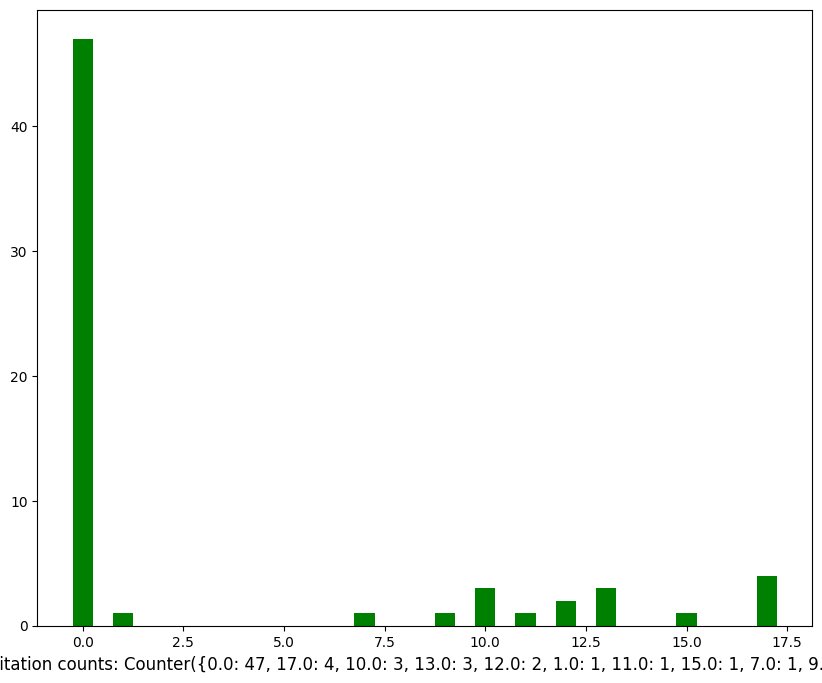

In [7]:
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA.flatten().tolist())):
    visit_dict[i]= rmax.nSA.flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.xlabel("visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
plt.savefig('ARCH2_histogram at' + str(datetime.now()) + '.png')

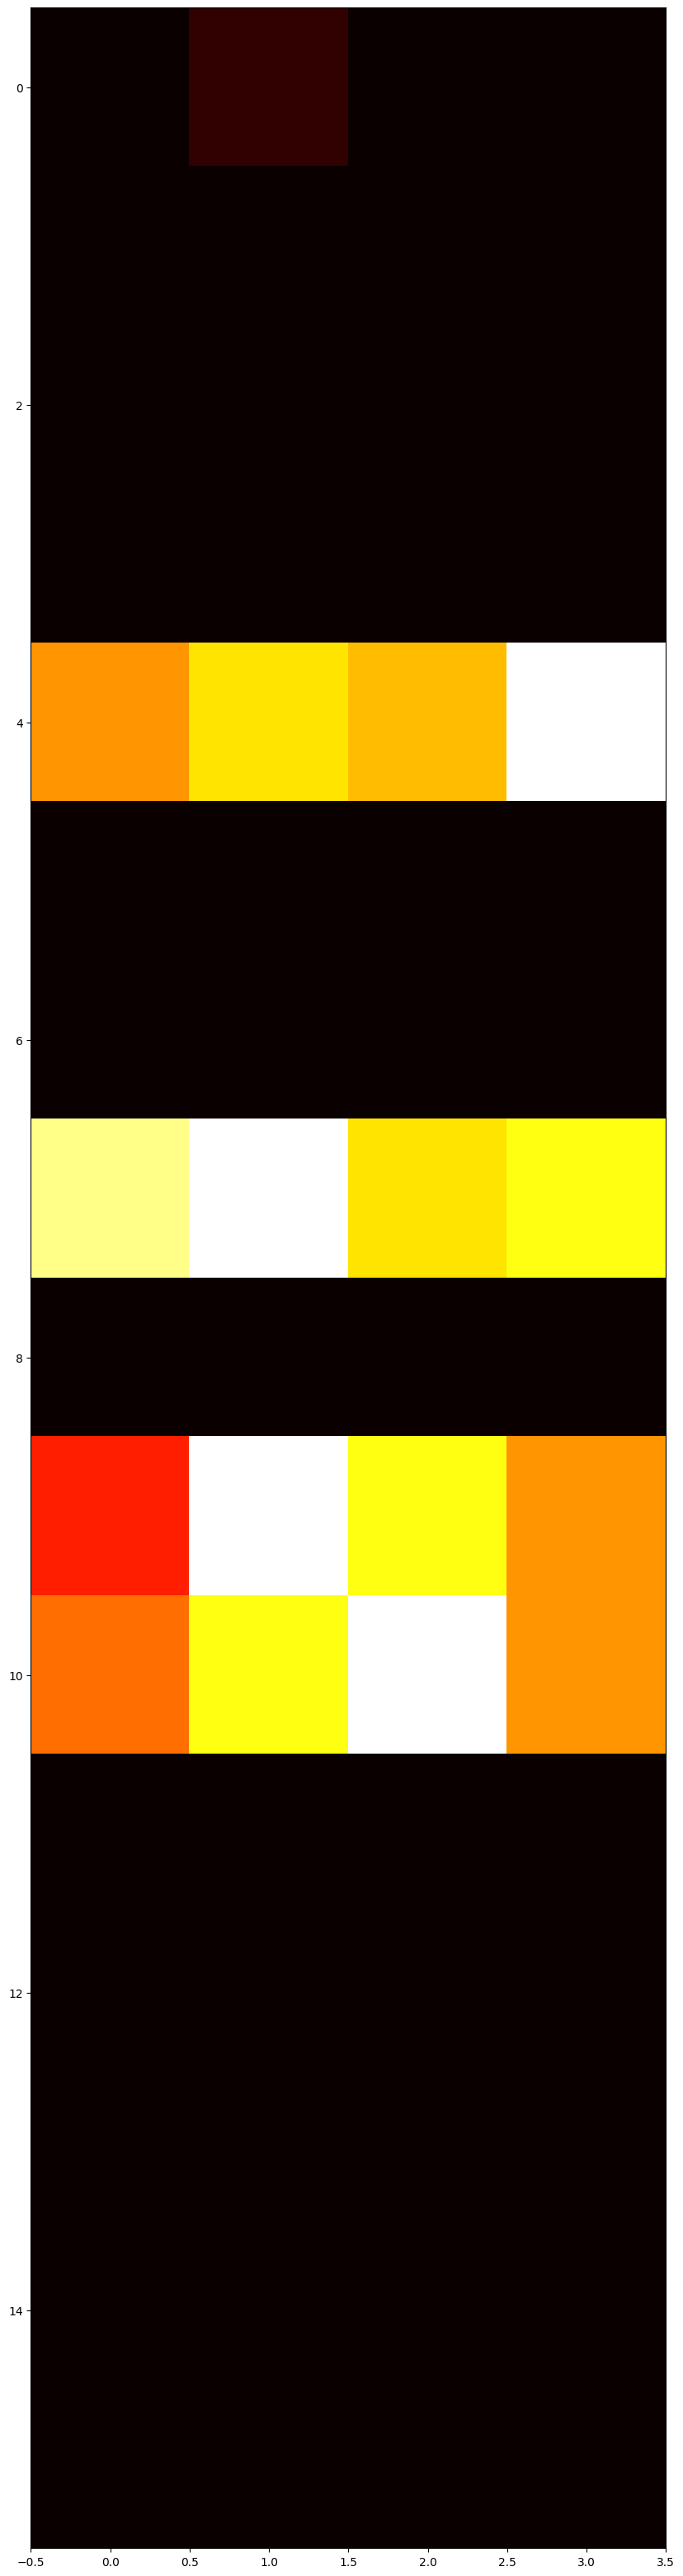

In [8]:
#generate heatmap
plt.imshow(rmax.nSA.cpu().numpy(), cmap='hot', interpolation='nearest')
figure1 = plt.gcf()
figure1.set_size_inches(50, 40)
plt.savefig('ARCH2_heatmap at' + str(datetime.now()) + '.png')

In [9]:
#generate reward mean
plot_rew_mean = torch.mean(plot_rew[:,:,0],1)
fig_handle = plt.plot(plot_rew_mean.cpu().numpy())

plt.xlabel("episodes \n Average reward of our agent: " + str(round(torch.mean(plot_rew[:,:,0],(0,1)).detach().item(), 3)) + 
          "\n Average reward of another agent: " + str(round(torch.mean(plot_rew[:,:,1],(0,1)).detach().item(), 3)))

plt.ylabel("Mean rewards")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)

plt.savefig('ARCH2_inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_mp1.png'  , dpi = 100)
plt.clf()

<Figure size 1000x800 with 0 Axes>

In [15]:
#generate learning curve at start
plot_rew_epi_start = torch.mean(plot_rew[:int(meta_epi*0.1), :, 0], 0)
fig_handle = plt.plot(plot_rew_epi_start.cpu().numpy())

plt.xlabel("steps \n mean reward in first "+ str(int(meta_epi*0.1)) + " episodes: " + str(torch.mean(plot_rew_epi_start, 0).item()))

plt.ylabel("Average learning rate of first " + str(int(meta_epi*0.1)) + " episodes")

figure3 = plt.gcf() # get current figure
figure3.set_size_inches(10, 8)

plt.savefig('ARCH2_inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_first_epi_mp1.png' , dpi = 100)
plt.clf()

<Figure size 1000x800 with 0 Axes>

In [16]:
#generate learning curve at end
plot_rew_epi_end = torch.mean(plot_rew[-int(meta_epi*0.1):, :, 0], 0)
fig_handle = plt.plot(plot_rew_epi_end.cpu().numpy())

plt.xlabel("steps \n mean reward in first "+ str(int(meta_epi*0.1)) + " episodes: " + str(torch.mean(plot_rew_epi_end, 0).item()))

plt.ylabel("Average learning rate of last " + str(int(meta_epi*0.1)) + " episodes")

figure4 = plt.gcf() # get current figure
figure4.set_size_inches(10, 8)

plt.savefig('ARCH2_inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_last_epi_mp1.png' , dpi = 100)
plt.clf()

<Figure size 1000x800 with 0 Axes>